In [ ]:
!pip install matplotlib

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-2-6053aaa1e05c>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarra

Episode 100/1000, Average Reward: 17.16
Episode 200/1000, Average Reward: 14.6
Episode 300/1000, Average Reward: 21.53
Episode 400/1000, Average Reward: 52.26
Episode 500/1000, Average Reward: 135.11
Episode 600/1000, Average Reward: 162.33
Episode 700/1000, Average Reward: 170.91
Episode 800/1000, Average Reward: 173.58
Episode 900/1000, Average Reward: 195.9
Episode 1000/1000, Average Reward: 200.0


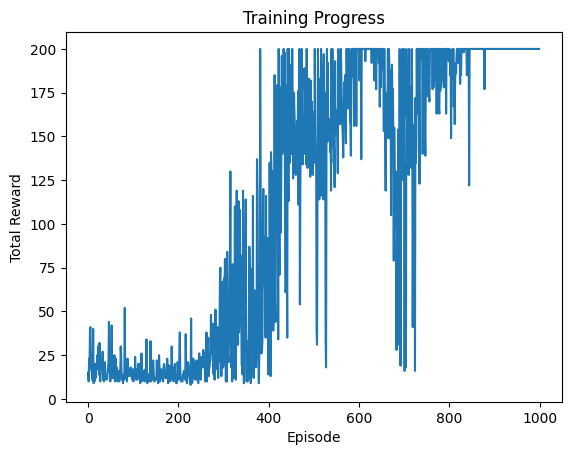

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 1, Total Reward: 500.0
Episode 2, Total Reward: 500.0
Episode 3, Total Reward: 500.0


In [ ]:
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.uint8)
        )

    def __len__(self):
        return len(self.memory)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.qnetwork_local = QNetwork(state_size, action_size)
        self.qnetwork_target = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=64)
        self.gamma = 0.99
        self.tau = 1e-3
        self.update_every = 4
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.replay_buffer) > self.replay_buffer.batch_size:
            experiences = self.replay_buffer.sample()
            self.learn(experiences)

    def act(self, state, eps=0.):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))
        Q_expected = self.qnetwork_local(states).gather(1, actions.unsqueeze(1))
        loss = self.criterion(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

# Create the environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Train the agent
n_episodes = 1000
max_t = 200
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
rewards_list = []

for i_episode in range(1, n_episodes + 1):
    state = env.reset()
    total_reward = 0
    for t in range(max_t):
        action = agent.act(state, eps_start)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    eps_start = max(eps_end, eps_decay * eps_start)
    rewards_list.append(total_reward)
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Reward: {np.mean(rewards_list[-100:])}")

# Plot the rewards
plt.plot(rewards_list)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.show()

# Visualize some episodes
for i in range(3):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        env.render()
    print(f"Episode {i+1}, Total Reward: {total_reward}")

env.close()


# Initialize replay memory D with capacity N
D = ReplayMemory(capacity=N)
# Initialize Q-network with random weights
Q = NeuralNetwork()
# Initialize target Q-network with the same weights as Q
Q_target = NeuralNetwork()
# Initialize exploration rate
epsilon = 1.0
# Main training loop
for episode in range(num_episodes):
    # Initialize state
    state = env.reset()
    
    # Initialize episode-specific variables
    total_reward = 0
    done = False
    
    # While episode is not done
    while not done:
        # Epsilon-greedy action selection
        if random() < epsilon:
            action = env.action_space.sample()  # Explore: choose random action
        else:
            action = argmax(Q(state))           # Exploit: choose best action
        
        # Execute action in environment
        next_state, reward, done, _ = env.step(action)
        
        # Store transition (state, action, reward, next_state, done) in replay memory
        D.push(state, action, reward, next_state, done)
        
        # Update total reward
        total_reward += reward
        
        # Sample random minibatch of transitions from replay memory
        minibatch = D.sample_batch(batch_size)
        
        # Compute Q-targets using target Q-network
        Q_targets = []
        for (s, a, r, s_next, d) in minibatch:
            if done:
                target = r
            else:
                target = r + gamma * max(Q_target(s_next))
            Q_targets.append(target)
        
        # Update Q-network using gradient descent
        Q.update(minibatch, Q_targets)
        
        # Every C steps, update target Q-network
        if steps % C == 0:
            Q_target.weights = Q.weights
        
        # Move to next state
        state = next_state
        
    # Decay exploration rate epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
    # Print episode statistics
    print(f"Episode {episode}: Total Reward = {total_reward}")
